# 【課題】量子データを使った量子機械学習

素粒子現象の分類で考えた{doc}`量子機械学習 <vqc_machine_learning>`は、古典的なデータを量子状態に符号化し、それを変分量子回路で学習するというものでした。

この課題では、量子シミュレーションで生成した量子状態を入力データとした量子機械学習を考えてみます。考える物理系はスピンが線状に並んだ1次元のイジング模型です。このスピン系の基底状態と時間発展状態を作り、それらからハミルトニアンのパラメータを決定するという**ハミルトニアン学習**の例を見てみます。決定したいパラメータは横磁場の強さを表す結合定数$h$です。

ここで考えるイジング模型のハミルトニアンは

$$
H = -J\sum_{j=0}^{L-2}Z_iZ_{i+1}-h\left(\sin\alpha\sum_{i=0}^{L-1}Z_i+\cos\alpha\sum_{i=0}^{L-1}X_i\right)
$$

として、$\alpha$というパラメータで横磁場と縦磁場の混ざり具合をコントロールするものとします。$\alpha=0$（$=\pi/2$）が純粋な横磁場（縦磁場）に対応しています。

まず、イジング模型の基底状態を生成するところから始めていきます。

## 基底状態の生成

{doc}`変分量子固有値ソルバー <vqe>`の方法を使って、基底状態を生成します。

まず必要な環境をセットアップします。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import TwoLocal, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SLSQP
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkRegressor

アンザッツとして、Ryゲートと制御Zゲートからなる一般的な量子回路を使ってみます。量子ビット数は2です。

/usr/local/lib/python3.10/dist-packages/dateutil/zoneinfo/__init__.py:26: UserWarning: I/O error(2): No such file or directory
  warnings.warn("I/O error({0}): {1}".format(e.errno, e.strerror))


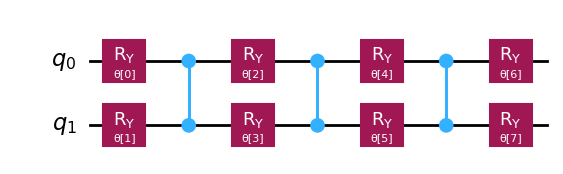

In [2]:
# VQEの設定
num_qubits = 2

ansatz = TwoLocal(num_qubits, "ry", "cz", reps=3)
ansatz.decompose().draw('mpl')

ハミルトニアンを返す関数を定義します。VQEパラメータの最適化には、SLSQPというオプティマイザーを使うことにします。

In [3]:
# Estimatorを使う
estimator = Estimator()
optimizer = SLSQP(maxiter=1000)  # オプティマイザー

# QiskitのVQEクラスを使う
vqe = VQE(estimator, ansatz, optimizer)

# 横磁場と縦磁場を持つイジング模型のハミルトニアンを定義
def get_hamiltonian(L, J, h, alpha=0):

    # タプル型の変数として、ハミルトニアンの各項からなるリストを定義
    # (1) パウリ列
    # (2) パウリ列に対応する量子ビットのインデックス
    # (3) パウリ列の係数
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, L)]

    # `from_sparse_list`を使い、SparsePauliOpとしてハミルトニアンを作る
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

例として、$\alpha = \pi/8$として、縦磁場と横磁場が混ざっているケースでの基底エネルギーをVQEで求めてみます。隣接ビット間の結合定数は$J = 0.2$、磁場との結合定数は$h = 1.2$とします。

In [4]:
# パラメータの設定
J = 0.2
h = 1.2
alpha = np.pi/8
H = get_hamiltonian(L=num_qubits, J=J, h=h, alpha=alpha)

# VQEで最低エネルギー状態を求める
result = vqe.compute_minimum_eigenvalue(H)
#print(result)
print(f'VQE energy value = {result.optimal_value:.5f}')

VQE energy value = -2.43940


系のサイズが小さいので、厳密対角化して最低エネルギーを計算することが可能です。

In [5]:
# ハミルトニアンを厳密体格化し、基底エネルギーを求める
numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=H)
ref_value = result.eigenvalue.real
print(f"Reference energy value = {ref_value:.5f}")

Reference energy value = -2.43940


## 基底状態からハミルトニアンパラメータを決定する

まず、異なる$h$の値に対応する基底状態のデータセットをVQEを使って生成します。単純化のため、`alpha`パラメータは0とします。

In [6]:
Nexp = 5   # あるhの値に対して行う実験回数
Ntrain = 20  # 実験あたりの訓練データの数 → この数だけhの値を変えたデータセットを作る

J = 0.2
alpha = 0

# hの値を[0, 1]の範囲でランダムに選ぶ
h_list = [np.random.rand() for _ in range(Ntrain)]
print(f'Input field strenghs = {h_list}')

Input field strenghs = [0.8282952772206197, 0.3005931948525733, 0.38199779954055324, 0.2214683352311546, 0.7701525510694609, 0.9435769008533663, 0.8760726519220848, 0.04318365617494391, 0.8668458135429298, 0.7775653772007558, 0.22119483277087582, 0.8108693160651269, 0.47998908610644464, 0.3972071587738766, 0.3799971913046627, 0.3982047013340866, 0.8484057459882937, 0.37837984540063896, 0.7834451420094203, 0.5555725075829074]


上で使ったのと同じ一般的な量子回路（`TwoLocal`）を使ってVQEを行い、得られたエネルギーの値をチェックしてみます。

In [7]:
# 一般的なアンザッツを使ってVQEを行う
vqe_ansatz = TwoLocal(num_qubits, "ry", "cz", parameter_prefix='x')

# OptimizerはSLSQPとする
optimizer = SLSQP(maxiter=1000)
estimator = Estimator()
vqe = VQE(estimator, vqe_ansatz, optimizer)

# 異なるhの値を持つ訓練データに対してVQEを行う
opt_vqe_energy = []
opt_vqe_params = []
for i in range(Ntrain):
    H = get_hamiltonian(L=num_qubits, J=J, h=h_list[i], alpha=alpha)
    result_vqe = vqe.compute_minimum_eigenvalue(H)
    opt_vqe_energy.append(result_vqe.optimal_value)
    opt_vqe_params.append(list(result_vqe.optimal_parameters.values()))
    print('VQE i =',i)

# エネルギー値を表示
for i in range(Ntrain):
    print(f'VQE[{i}] energy value = {opt_vqe_energy[i]:.5f}')

VQE i = 0


VQE i = 1
VQE i = 2


VQE i = 3
VQE i = 4


VQE i = 5
VQE i = 6
VQE i = 7


VQE i = 8
VQE i = 9
VQE i = 10


VQE i = 11
VQE i = 12
VQE i = 13


VQE i = 14
VQE i = 15
VQE i = 16


VQE i = 17
VQE i = 18


VQE i = 19
VQE[0] energy value = -1.66862
VQE[1] energy value = -0.63358
VQE[2] energy value = -0.78974
VQE[3] energy value = -0.48600
VQE[4] energy value = -1.55324
VQE[5] energy value = -1.89772
VQE[6] energy value = -1.76352
VQE[7] energy value = -0.20001
VQE[8] energy value = -1.74519
VQE[9] energy value = -1.56794
VQE[10] energy value = -0.48550
VQE[11] energy value = -1.63402
VQE[12] energy value = -0.98059
VQE[13] energy value = -0.81920
VQE[14] energy value = -0.78587
VQE[15] energy value = -0.82114
VQE[16] energy value = -1.70856
VQE[17] energy value = -0.78274
VQE[18] energy value = -1.57960
VQE[19] energy value = -1.12900


厳密対角化して得られたエネルギーと比較して、VQEの結果を確認します。

In [8]:
numpy_solver = NumPyMinimumEigensolver()
for i in range(Ntrain):
    H = get_hamiltonian(L=num_qubits, J=J, h=h_list[i], alpha=alpha)
    result = numpy_solver.compute_minimum_eigenvalue(operator=H)
    ref_value = result.eigenvalue.real
    print(f"Reference[{i}] energy value = {ref_value:.5f}")

Reference[0] energy value = -1.66862
Reference[1] energy value = -0.63358
Reference[2] energy value = -0.78974
Reference[3] energy value = -0.48600
Reference[4] energy value = -1.55324
Reference[5] energy value = -1.89772
Reference[6] energy value = -1.76352
Reference[7] energy value = -0.21785
Reference[8] energy value = -1.74519
Reference[9] energy value = -1.56794
Reference[10] energy value = -0.48550
Reference[11] energy value = -1.63402
Reference[12] energy value = -0.98059
Reference[13] energy value = -0.81920
Reference[14] energy value = -0.78587
Reference[15] energy value = -0.82114
Reference[16] energy value = -1.70856
Reference[17] energy value = -0.78274
Reference[18] energy value = -1.57960
Reference[19] energy value = -1.12900


ここで量子機械学習用の回路を作り、ハミルトニアンパラメータの決定を行います。最初に最適化したVQEの回路（`vqe_ansatz`）を置いて基底状態を作り、その後に学習用の量子回路を置いてパラメータ決定をすることを考えます。これはVQE回路を特徴量マップとしてみなすやり方で、こうすることで最適化したVQE回路のパラメータを入力データのように扱うことができます。

In [9]:
# 最初の量子ビットを計算基底で測定する
pauli = 'I' * (num_qubits - 1)
pauli += 'Z'
obs = SparsePauliOp([pauli], coeffs = 10.)

# 損失関数の値を表示するCallback関数
def callback_graph(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)

# 学習用量子回路のCX-RYレイヤーの数
nlayer = 3  # CX-RY layers

result_exp = []
regressor_exp = []
objective_func_vals_exp = []

# 実験をNexp回繰り返す
for iexp in range(Nexp):
    
    qc = QuantumCircuit(num_qubits)
    
    # VQE回路
    qc.compose(vqe_ansatz, inplace=True)

    # 学習用の量子回路
    qnn_ansatz = RealAmplitudes(num_qubits=num_qubits, reps=nlayer, parameter_prefix='theta')
    qc.compose(qnn_ansatz, inplace=True)

    # 学習パラメータの初期値：[0, pi]でランダムに設定
    initial_weights = np.random.rand((nlayer+1)*num_qubits)*np.pi

    # EstimatorQNNクラスを使う
    qnn = EstimatorQNN(
        circuit = qc,
        input_params = vqe_ansatz.parameters,
        weight_params = qnn_ansatz.parameters,
        observables = obs
    )

    # NeuralNetworkRegressorクラスを使い、回帰問題としてhの値を予測する
    regressor = NeuralNetworkRegressor(
        neural_network = qnn,
        loss = "squared_error",
        optimizer = SLSQP(maxiter=1000),
        warm_start = True,
        initial_point = initial_weights,
        callback = callback_graph
    )

    objective_func_vals = []
    # 最適化したVQE回路パラメータを入力データ、上で設定したhの値を出力データとして回帰を行う
    result_regres = regressor.fit(np.array(opt_vqe_params),np.array(h_list))
    result_exp.append(result_regres)
    regressor_exp.append(regressor)
    objective_func_vals_exp.append(objective_func_vals)

    print(f'iexp = {iexp}')

iexp = 0


KeyboardInterrupt: 

損失関数のプロファイルを表示する。

In [ ]:
fig = plt.figure(facecolor="w")
ax = fig.add_subplot(1, 1, 1)
plt.title('Objective function value against iteration')
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
for iexp in range(Nexp):
    plt.plot(range(len(objective_func_vals_exp[iexp])), objective_func_vals_exp[iexp])
plt.show()

設定した$h$の値（横軸）と予測した$h$の値（縦軸）をプロットする。

In [ ]:
train_pred_exp = []
for iexp in range(Nexp):
    train_pred = regressor_exp[iexp].predict(np.array(opt_vqe_params))
    train_pred_exp.append(train_pred)
    plt.scatter(h_list, train_pred, label='training')
plt.title('True vs Predicted values')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.xlim(-0.05,1.1)
plt.ylim(-0.15,1.25)
plt.plot([-0.2,1.2],[-0.2,1.2],'k--')
plt.show()

ここからが問題です。

### 問題1：VQEの量子回路を変更する

ここまでは`TwoLocal`という一般的な量子回路を使ってVQEを行いましたが、より問題に適した量子回路にVQEの回路を変更することを考えます。ここではイジング模型のハミルトニアンを扱っているので、そのハミルトニアンを構成するパウリ演算子を表現する量子回路（**Hamiltonian Variational Ansatz**、**HVA**と呼ばれる）にしてみましょう。

上で

In [ ]:
# 一般的なアンザッツを使ってVQEを行う
vqe_ansatz = TwoLocal(num_qubits, "ry", "cz", parameter_prefix='x')

としている部分がありますが、ここをイジング模型のハミルトニアン

$$
H = -J\sum_{j=0}^{L-2}Z_iZ_{i+1}-h\sum_{i=0}^{L-1}X_i
$$

を表現できるように変更してください。`new_theta_x`という関数は使わなくても書けますが、パラメータ`theta_x`を置きたいところに`new_theta_x()`と書くと、自動でパラメータを追加してくれます。

**ヒント1**
初期状態に注意してください。ハミルトニアンの形を模倣した量子回路を使った場合、一般的にその回路で生成される状態はヒルベルト空間の一部のみを張るため、初期状態を正しく選んであげないと物理的に意味のある状態に到達できない可能性があります。

**ヒント2**
このハミルトニアンには$J$と$h$の二つの結合定数がありますが、どちらも量子ビットに依存しない定数です。

In [ ]:
vqe_ansatz = QuantumCircuit(num_qubits)

theta_x = ParameterVector('theta_x')
def new_theta_x():
    theta_x.resize(len(theta_x) + 1)
    return theta_x[-1]

##################
### EDIT BELOW ###
##################

#vqe_ansatz.?

##################
### EDIT ABOVE ###
##################

# OptimizerはSLSQPとする
optimizer = SLSQP(maxiter=1000)
estimator = Estimator()
vqe = VQE(estimator, vqe_ansatz, optimizer)

# 異なるhの値を持つ訓練データに対してVQEを行う
opt_vqe_energy = []
opt_vqe_params = []
for i in range(Ntrain):
    H = get_hamiltonian(L=num_qubits, J=J, h=h_list[i], alpha=alpha)
    result_vqe = vqe.compute_minimum_eigenvalue(H)
    opt_vqe_energy.append(result_vqe.optimal_value)
    opt_vqe_params.append(list(result_vqe.optimal_parameters.values()))
    print('VQE i =',i)

# エネルギー値を表示
for i in range(Ntrain):
    print(f'VQE[{i}] energy value = {opt_vqe_energy[i]:.5f}')

イジング模型のHVAが実装できれば、`TwoLocal`に比べて少ない学習パラメータで基底エネルギーに到達できると思います。上で求めた厳密対角化の答えと比較して、確認してください。

## 時間発展状態を使ってハミルトニアンパラメータを決定する

次に、ハミルトニアンによる時間発展を行った状態に対して同じ問題を考えてみます。

ハイゼンベルクモデルの時間発展（[物理系を表現する](https://kterashi.github.io/qc-workbook/ja/dynamics_simulation.html#id14)）の実習で、ハミルトニアンの時間発展演算子は鈴木・トロッター分解で近似できることを見ました。ここでも同様に、イジング模型のハミルトニアンに対して鈴木・トロッターの方法で時間発展状態を作り、その状態からパラメータ$h$を決定してみます。時間発展させる回路に使ったパラメータを出力状態から求める問題なので、すでに答えは知っているわけですが、時間発展がどういう影響を与えるのかを見ようという訳です。

### 問題2：イジング模型の時間発展を行う量子回路を作る

以下のセルで、鈴木・トロッターの時間ステップを`num_steps`回実行する回路を作ってください。$h$の値は入力データとして与えるので、`Parameter`で定義した`h_param`を使うとします。`num_spins`は量子ビット数です。

**ヒント1**
上と同じく、初期状態に注意してください。

**ヒント2**
周期境界条件を課す（$\sigma_n^Z$を$\sigma_0^Z$と同一視する）ことに注意してください。

In [ ]:
def trotter_ising_circuit(num_spins, J, num_steps):
    
    circuit = QuantumCircuit(num_spins)

    # hをパラメータ化して変更できるようにする    
    h_param = Parameter('h_param')

    ##################
    ### EDIT BELOW ###
    ##################

    #circuit.?

    ##################
    ### EDIT ABOVE ###
    ##################

    return circuit

鈴木・トロッターを1時間ステップ分に相当する回路を表示する。

In [ ]:
num_steps = 1

circuit_single_step = trotter_ising_circuit(num_qubits, J, num_steps)
circuit_single_step.draw('mpl')

1時間ステップ分の鈴木・トロッターで作った状態でパラメータ決定を行う。

In [ ]:
result_exp = []
regressor_exp = []
objective_func_vals_exp = []

# 実験をNexp回繰り返す
for iexp in range(Nexp):
    
    qc = QuantumCircuit(num_qubits)
    
    # 時間発展用の回路
    state_prep = trotter_ising_circuit(num_qubits, J, num_steps)
    qc.compose(state_prep, inplace=True)
    
    # 学習用の量子回路
    qnn_ansatz = RealAmplitudes(num_qubits=num_qubits, reps=nlayer, parameter_prefix='theta')
    qc.compose(qnn_ansatz, inplace=True)

    # 学習パラメータの初期値：[0, pi]でランダムに設定
    initial_weights = np.random.rand((nlayer+1)*num_qubits)*np.pi

    # EstimatorQNNクラスを使う
    qnn = EstimatorQNN(
        circuit = qc,
        input_params = state_prep.parameters,
        weight_params = qnn_ansatz.parameters,
        observables = obs
    )

    # NeuralNetworkRegressorクラスを使い、回帰問題としてhの値を予測する
    regressor = NeuralNetworkRegressor(
        neural_network = qnn,
        loss = "squared_error",
        optimizer = SLSQP(maxiter=1000),
        warm_start = True,
        initial_point = initial_weights,
        callback = callback_graph
    )

    objective_func_vals = []
    # 上で設定したhの値を入力データとして時間発展させ、出力状態からhの回帰を行う
    result_regres = regressor.fit(np.array([[i] for i in h_list]),np.array(h_list))
    result_exp.append(result_regres)
    regressor_exp.append(regressor)
    objective_func_vals_exp.append(objective_func_vals)

    print(f'iexp = {iexp}')

損失関数のプロファイルを表示する

In [ ]:
fig = plt.figure(facecolor="w")
ax = fig.add_subplot(1, 1, 1)
plt.title('Objective function value against iteration')
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
for iexp in range(Nexp):
    plt.plot(range(len(objective_func_vals_exp[iexp])), objective_func_vals_exp[iexp])
plt.show()

設定した$h$の値（横軸）と予測した$h$の値（縦軸）をプロットする。

In [ ]:
train_pred_exp = []
for iexp in range(Nexp):
    train_pred = regressor_exp[iexp].predict(np.array([[i] for i in h_list]))
    train_pred_exp.append(train_pred)
    plt.scatter(h_list, train_pred, label='training')
plt.title('True vs Predicted values')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.xlim(-0.05,1.1)
plt.ylim(-0.15,1.25)
plt.plot([-0.2,1.2],[-0.2,1.2],'k--')
plt.show()

どのような結果が得られたでしょうか。

### 問題3：鈴木・トロッターの時間ステップを増やした場合

鈴木・トロッターの時間ステップを増やすと、$h$パラメータの決定精度が変わっていくと思います。その様子を調べ、考察してください。


**提出するもの**
- 問題1と問題2の量子回路
- 問題3の結果と、その考察